# 4.2 Classifying newswires: a multiclass classification example

In this section, you’ll build a network to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of *multiclass classification*; and because each data point should be classified into only one category, the problem is more specifically an instance of *single-label, multiclass classification*. If each data point could belong to multiple categories (in this case, topics), you’d be facing a *multilabel, multiclass classification* problem.

## 4.2.1 The Reuters dataset
You’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [1]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

As with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.
You have 8,982 training examples and 2,246 test examples:

In [2]:
print(len(train_data))
print(len(test_data))

8982
2246


As with the IMDB reviews, each example is a list of integers (word indices):

In [3]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [4]:
print(train_labels[10])

3


## 4.2.2 Preparing the data
### *Encoding the data*

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called *categorical encoding*. For a more detailed explanation of one-hot encoding, see section 6.1. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of
the label index. Here’s an example:

In [6]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you’ve already seen in action
in the MNIST example:

In [7]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## 4.2.3 Building your network
This topic-classification problem looks similar to the previous movie-review classification problem: in both cases, you’re trying to classify short snippets of text. But there is a new constraint here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

 In a stack of `Dense` layers like that you’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may
be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

 For this reason you’ll use larger layers. Let’s go with 64 units.

### *Model definition*

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

There are two other things you should note about this architecture:
- You end the network with a `Dense` layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
- The last layer uses a `softmax` activation. You saw this pattern in the MNIST example. It means the network will output a *probability distribution* over the 46 different output classes—for every input sample, the network will produce a 46-dimensional output vector, where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

### *Compiling the model*
The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels. By minimizing the distance between these two distributions, you train the network to output something as close as possible to the true labels.

In [9]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 4.2.4 Validating your approach
### *Setting aside a validation set*
Let’s set apart 1,000 samples in the training data to use as a validation set.

In [10]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

### *Training the model*
Now, let’s train the network for 20 epochs.

In [11]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 41ms/step - loss: 2.6056 - accuracy: 0.5298 - val_loss: 1.7766 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 0s 27ms/step - loss: 1.4945 - accuracy: 0.6884 - val_loss: 1.3752 - val_accuracy: 0.6900
Epoch 3/20
16/16 [==============================] - 0s 27ms/step - loss: 1.1599 - accuracy: 0.7408 - val_loss: 1.2083 - val_accuracy: 0.7420
Epoch 4/20
16/16 [==============================] - 0s 27ms/step - loss: 0.9480 - accuracy: 0.7930 - val_loss: 1.0786 - val_accuracy: 0.7490
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.7858 - accuracy: 0.8260 - val_loss: 1.0097 - val_accuracy: 0.7900
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6509 - accuracy: 0.8554 - val_loss: 0.9581 - val_accuracy: 0.7880
Epoch 7/20
16/16 [==============================] - 0s 27ms/step - loss: 0.5436 - accuracy: 0.8812 - val_loss: 0.9267 - val_accuracy: 0.8000
Epoch 8/20
16

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### *Plotting the training and validation loss*

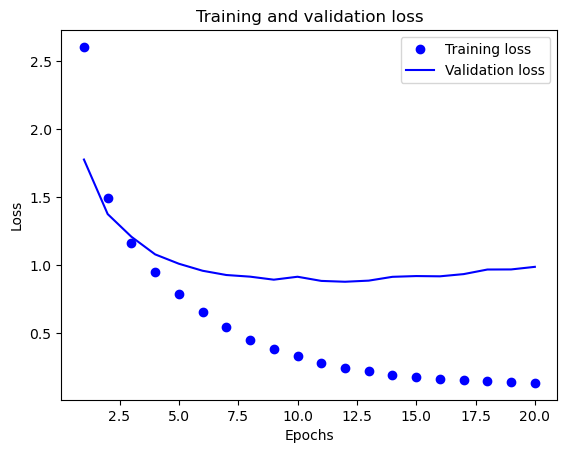

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### *Plotting the training and validation accuracy*

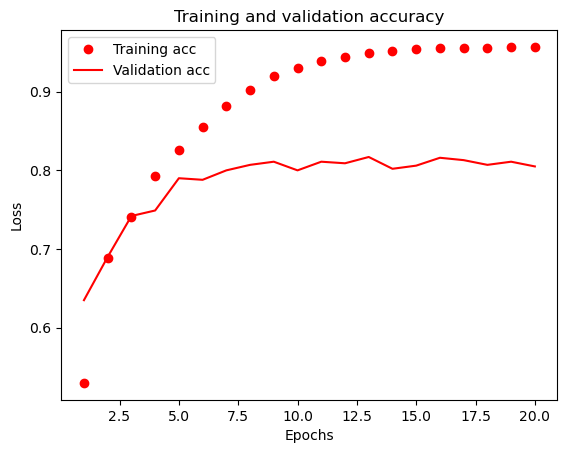

In [14]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The network begins to overfit after nine epochs. Let’s train a new network from scratch for nine epochs and then evaluate it on the test set.
### *Retraining a model from scratch*

In [15]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=9, batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 24ms/step - loss: 2.5612 - accuracy: 0.5246
Epoch 2/9
18/18 [==============================] - 0s 23ms/step - loss: 1.4487 - accuracy: 0.6946
Epoch 3/9
18/18 [==============================] - 0s 25ms/step - loss: 1.1211 - accuracy: 0.7477
Epoch 4/9
18/18 [==============================] - 0s 23ms/step - loss: 0.9155 - accuracy: 0.7978
Epoch 5/9
18/18 [==============================] - 0s 23ms/step - loss: 0.7523 - accuracy: 0.8336
Epoch 6/9
18/18 [==============================] - 0s 24ms/step - loss: 0.6213 - accuracy: 0.8633
Epoch 7/9
18/18 [==============================] - 0s 23ms/step - loss: 0.5133 - accuracy: 0.8887
Epoch 8/9
18/18 [==============================] - 0s 23ms/step - loss: 0.4251 - accuracy: 0.9077
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9029 - accuracy: 0.7903


In [16]:
results

[0.9028890132904053, 0.7902938723564148]

This approach reaches an accuracy of ~80%. With a balanced binary classification
problem, the accuracy reached by a purely random classifier would be 50%. But in
this case, we have 46 classes, and they may not be equally represented. What would be
the accuracy of a random baseline? We could try quickly implementing one to check
this empirically:

In [17]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)

In [18]:
np.array(test_labels) == np.array(test_labels_copy)

array([False, False, False, ...,  True, False, False])

In [19]:
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1803205699020481

As you can see, a random classifier would score around 19% classification accuracy, so
the results of our model seem pretty good in that light. 

## 4.2.5 Generating predictions on new data
You can verify that the `predict` method of the model instance returns a probability distribution over all 46 topics. Let’s generate topic predictions for all of the test data.
### *Generating predictions for new data*

In [20]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


Each entry in `predictions` is a vector of length 46:

In [21]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [22]:
np.sum(predictions[0])

0.9999999

The largest entry is the predicted class—the class with the highest probability:

In [23]:
np.argmax(predictions[0])

3

## 4.2.6 A different way to handle the labels and the loss
We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like this:
`y_train = np.array(train_labels)
y_test = np.array(test_labels)`
The only thing this approach would change is the choice of the loss function. The loss function used above, `categorical_crossentropy`, expects the labels to follow a categorical encoding. With integer labels, you should use `sparse_categorical_crossentropy`:

`model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])`

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## 4.2.7 The importance of having sufficiently large intermediate layers
We mentioned earlier that because the final outputs are 46-dimensional, you should
avoid intermediate layers with many fewer than 46 hidden units. Now let’s see what
happens when you introduce an information bottleneck by having intermediate layers
that are significantly less than 46-dimensional: for example, 4-dimensional.

In [28]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train, partial_y_train, 
          epochs=20, batch_size=128, 
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 2.9926 - accuracy: 0.3733 - val_loss: 2.3321 - val_accuracy: 0.4270
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 1.8363 - accuracy: 0.5564 - val_loss: 1.5944 - val_accuracy: 0.6750
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 1.3347 - accuracy: 0.7048 - val_loss: 1.3803 - val_accuracy: 0.6860
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 1.1466 - accuracy: 0.7185 - val_loss: 1.3011 - val_accuracy: 0.6990
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 1.0280 - accuracy: 0.7342 - val_loss: 1.2623 - val_accuracy: 0.6940
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 0.9423 - accuracy: 0.7509 - val_loss: 1.2701 - val_accuracy: 0.7040
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.8684 - accuracy: 0.7656 - val_loss: 1.2405 - val_accuracy: 0.6980
Epoch 8/20
63

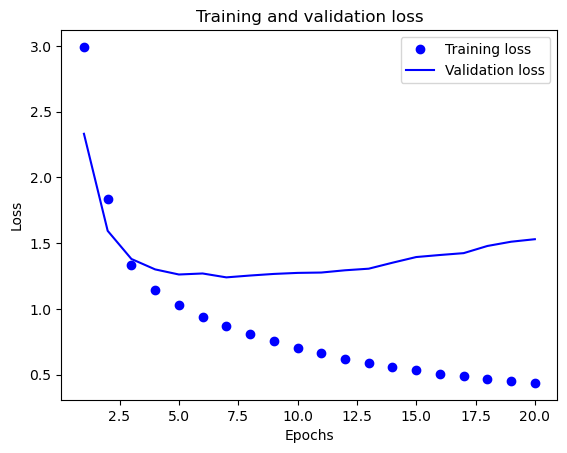

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

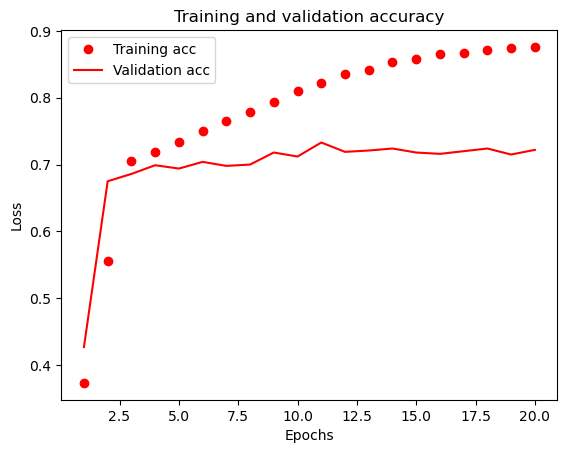

In [30]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram *most* of the necessary information into these eight-dimensional representations, but not all of it.

## 4.2.8 Further experiments
- Try using larger or smaller layers: 32 units, 128 units, and so on.
- You used two hidden layers. Now try using a single hidden layer, or three hidden layers.

## 4.2.9 Wrapping up
Here’s what you should take away from this example:
- If you’re trying to classify data points among *N* classes, your network should end with a Dense layer of size *N*.
- In a single-label, multiclass classification problem, your network should end with a `softmax` activation so that it will output a probability distribution over the *N* output classes.
- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions
output by the network and the true distribution of the targets.
- There are two ways to handle labels in multiclass classification:
    - Encoding the labels via categorical encoding (also known as one-hot encoding) and using `categorical_crossentropy` as a loss function
    - Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function
- If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small. 

### *cce vs. scce*
In this case (multiclass, single-label), we can calculate using two different methods: Categorical Cross-Entropy and Sparse Categorical Cross-Entropy. We can explain themas following:
- `categorical_crossentropy` (cce) produces a *one-hot array* containing the probable match for each category,
- `sparse_categorical_crossentropy` (scce) produces a *category index* of the most likely matching category.
Consider a classification problem with 5 categories (or classes).

In the case of cce, the one-hot target may be [0, 1, 0, 0, 0] and the model may predict [.2, .5, .1, .1, .1] (probably right).
In the case of scce, the target index may be [1] and the model may predict: [.5].
Consider now a classification problem with 3 classes.

In the case of cce, the one-hot target might be [0, 0, 1] and the model may predict [.5, .1, .4] (probably inaccurate, given that it gives more probability to the first class)
In the case of scce, the target index might be [0], and the model may predict [.5]
Many categorical models produce scce output because you save space, but lose A LOT of information (for example, in the 2nd example, index 2 was also very close.) I generally prefer cce output for model reliability.

There are a number of situations to use scce, including:
- when your classes are mutually exclusive, i.e. you don’t care at all about other close-enough predictions,
- the number of categories is large to the prediction output becomes overwhelming.